# DeepFloyd's IF on a Free Tier Google Colab

*Running one of the most powerful open-source text to image models on a free tier google colab with* 🤗 🧨 *Diffusers*

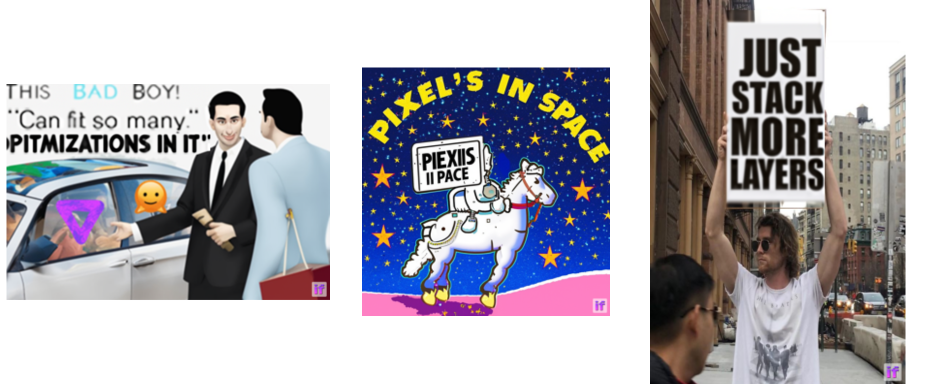


## IF

DeepFloyd's IF is a new text to image model. IF is particularly good at generating images that include text due to the use of [T5](https://huggingface.co/docs/transformers/model_doc/t5) as its text encoder. 

Many of the popular text to image diffusion models such as stable diffusion operate in "latent" space i.e. their neural network is trained to operate on compressed images. In contrast, IF operates directly on uncompressed image pixels. 

While T5 and pixel space diffusion processes are effective, they are both quite resource intensive. In 32 bit precision, T5, IF's text to image unet, and IF's upscaler unet have 18 GB, 17 GB, and 5 GB of respective weights. Compare this to stable diffusion 2.1's text encoder and unet having 1.4 GB and 3.5 GB of respective 32 bit precision weights.

## Optimizing IF to run on less powerful hardware

At Hugging Face, our mission is to democratize good machine learning. Part of democratizing includes making models available to run on more than just the latest and greatest hardware.

The deep learning community has created world class tools to run resource intensive models on consumer accessible hardware. 🤗 accelerate and bitsandbytes provide utilities for working with [large models](https://huggingface.co/docs/accelerate/usage_guides/big_modeling) and [8 bit quantization](https://github.com/TimDettmers/bitsandbytes#features). 

Diffusers provides consistent APIs to use accelerate and bitsandbytes with all models in the library. With all three libraries, you can even run IF on a free tier Google colab. 

We will use bitsandbyts' 8 bit quantization to load T5 in just 8 GB of RAM. 

Diffusers supports weight offloading which can move weights selectively to the GPU as they're needed. However, weight offloading still requires enough CPU RAM to store the rest of the weights when they're not being used. The Google colab free tier is both CPU RAM constrained as well as GPU VRAM constrained.

Diffusers supports modularly loading individual model components i.e. we can load the text encoder without loading the unet. We will use this modular loading to avoid exhausting the available CPU RAM and GPU VRAM.

Let's go!

## Available resources

The Google colab free tier comes with around 13 GB CPU RAM

In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13297192 kB


And an NVIDIA T4 with 16 GB VRAM

In [ ]:
!nvidia-smi

Sun Apr 23 23:14:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   1335MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install dependencies 

Some optimizations can require up to date versions of dependencies. If you are having issues, please double check and upgrade versions.

In [ ]:
! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  safetensors~=0.3 \
  sentencepiece~=0.1 \
  accelerate~=0.18 \
  bitsandbytes~=0.38 \
  torch~=2.0

## Text to image generation

We will walk step by step through text to image generation with IF using Diffusers. We will explain briefly APIs and optimizations, but more in-depth explanations can be found in the official documentation for [Diffusers](https://huggingface.co/docs/diffusers/index), [Transformers](https://huggingface.co/docs/transformers/index), [Accelerate](https://huggingface.co/docs/accelerate/index), and [bitsandbytes](https://github.com/TimDettmers/bitsandbytes).

### 1. Load text encoder

We will load T5 using 8 bit quantization. Transformers directly supports [bitsandbytes](https://huggingface.co/docs/transformers/main/en/main_classes/quantization#load-a-large-model-in-8bit) through the `load_in_8bit` flag. 

The flag `variant='8bit'` will download pre-quantized weights.

We also use the `device_map` flag to allow Transformers to offload model layers to the CPU or disk. Transformers big modeling supports arbitrary device maps which can be used to separately load model parameters directly to available devices. Passing `auto` will automatically create a device map. See the transformers [docs](https://huggingface.co/docs/accelerate/usage_guides/big_modeling#designing-a-device-map) for more information.

In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0",
    subfolder="text_encoder", 
    device_map="auto", 
    load_in_8bit=True, 
    variant="8bit"
)

### 2. Create text embeddings

The Diffusers API for accessing diffusion models is the `DiffusionPipeline` class and its subclasses. Each instance of `DiffusionPipeline` is a fully self contained set of methods and models for running diffusion networks. We can override the models it uses by passing alternative instances as keyword arguments to `from_pretrained`. 

In this case, we pass `None` for the `unet` argument so no unet will be loaded. This allows us to only run the text embedding portion of the diffusion process.

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0", 
    text_encoder=text_encoder, # pass the previously instantiated 8 bit text encoder
    unet=None, 
    device_map="auto"
)

IF also comes with a super resolution pipeline. We will save the prompt embeddings so that we can later directly pass them to the super resolution pipeline. This allows the super resolution pipeline to be loaded without a text encoder.

In [ ]:
prompt = 'a photograph of an astronaut riding a horse holding a sign that says "Pixel\'s in space"'
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

### 3. Free memory 

Once the prompt embeddings have been created. We do not need the text encoder anymore. However, it is still in memory on the GPU. We need to remove it so that we can load the unet.

Freeing memory used by Pytorch models requires garbage collecting the python object which points to the actual memory allocated on the GPU. 

First, use the python keyword `del` to delete the python objects which reference allocated GPU memory



In [ ]:
del text_encoder
del pipe

Next, we will have to manually trigger python garbage collection to make sure that the actual GPU memory is freed. 

Additionally, we will call `torch.cuda.empty_cache`. This method isn't strictly necessary as the cached cuda memory will be immediately available for further allocations, but freeing it lets us verify in the colab UI that the memory is freed.

We'll use a "flush memory" helper function.

In [ ]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
flush()

### 4. Run the main diffusion process

With our now available GPU memory, we can re-load the `DiffusionPipeline` with only the unet for running the main diffusion process.

The `variant` and `torch_dtype` flags are used by Diffusers to download and load the weights in 16 bit floating point format.

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Often, we directly pass the text prompt to `DiffusionPipeline.__call__`. However, we previously computed our text embeddings which we can pass instead.

IF also comes with a super resolution diffusion process. Setting `output_type='pt'` will return raw Pytorch tensors instead of a PIL image. The Pytorch tensors can be directly passed to the super resolution pipeline.

In [ ]:
generator = torch.Generator().manual_seed(1)
image = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

We can manually convert the raw tensors to view the 64x64 intermediate results.

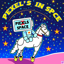

In [ ]:
pil_image = image
pil_image = (pil_image / 2 + 0.5).clamp(0, 1)
pil_image = pil_image.cpu().permute(0, 2, 3, 1).float().numpy()
pil_image = DiffusionPipeline.numpy_to_pil(pil_image)
pipe.apply_watermark(pil_image)

pil_image[0]

We always follow the same steps to free GPU memory

In [ ]:
del pipe

In [ ]:
flush()

### 5. Super Resolution

IF comes with a separate diffusion process for performing super resolution on the produced image.

We run each IF diffusion process through its own pipeline. The super resolution pipeline can be loaded with a text encoder if needed. However, we will usually have pre-computed text embeddings from the first IF pipeline. If so, load the pipeline without the text encoder.

Create the pipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Run inference

In [ ]:
image = pipe(
    image=image, 
    prompt_embeds=prompt_embeds, 
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

View output image

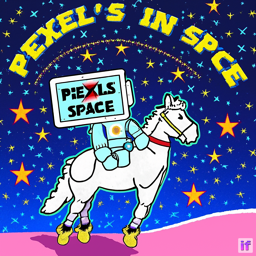

In [ ]:
pil_image = image
pil_image = (pil_image / 2 + 0.5).clamp(0, 1)
pil_image = pil_image.cpu().permute(0, 2, 3, 1).float().numpy()
pil_image = DiffusionPipeline.numpy_to_pil(pil_image)
pipe.apply_watermark(pil_image)

pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

### 6. Stable Diffusion x4 Upscaler

The officially recommended method of further super resolution is to use the pre-existing stable diffusion x4 upscaler model. The stable diffusion x4 upscaler model is already available in Diffusers. 

🤗 🧨 Diffusers makes independently developed diffusion models easily composable!

Create the pipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Run inference

In [ ]:
pil_image = pipe(prompt, generator=generator, image=image).images

Unlike the IF pipelines, the IF watermark will not be added by default to outputs from the stable diffusion x4 upscaler pipeline.

We will define a helper function to watermark the outputs.

In [ ]:
from PIL import Image
from huggingface_hub import hf_hub_download
from diffusers.utils import PIL_INTERPOLATION

watermark_path = hf_hub_download("diffusers/IF", repo_type="dataset", filename="watermark.png")
watermark_image = Image.open(watermark_path)

def sd_x4_apply_watermark(images):
  h = images[0].height
  w = images[0].width

  stability_x4_upscaler_sample_size = 128

  coef = min(h / stability_x4_upscaler_sample_size, w / stability_x4_upscaler_sample_size)
  img_h, img_w = (int(h / coef), int(w / coef)) if coef < 1 else (h, w)

  S1, S2 = 1024**2, img_w * img_h
  K = (S2 / S1) ** 0.5
  wm_size, wm_x, wm_y = int(K * 62), img_w - int(14 * K), img_h - int(14 * K)

  wm_img = watermark_image.resize((wm_size, wm_size), PIL_INTERPOLATION["bicubic"], reducing_gap=None)

  for pil_img in images:
    pil_img.paste(wm_img, box=(wm_x - wm_size, wm_y - wm_size, wm_x, wm_y), mask=wm_img.split()[-1])

  return images

In [ ]:
sd_x4_apply_watermark(pil_image)

View output image

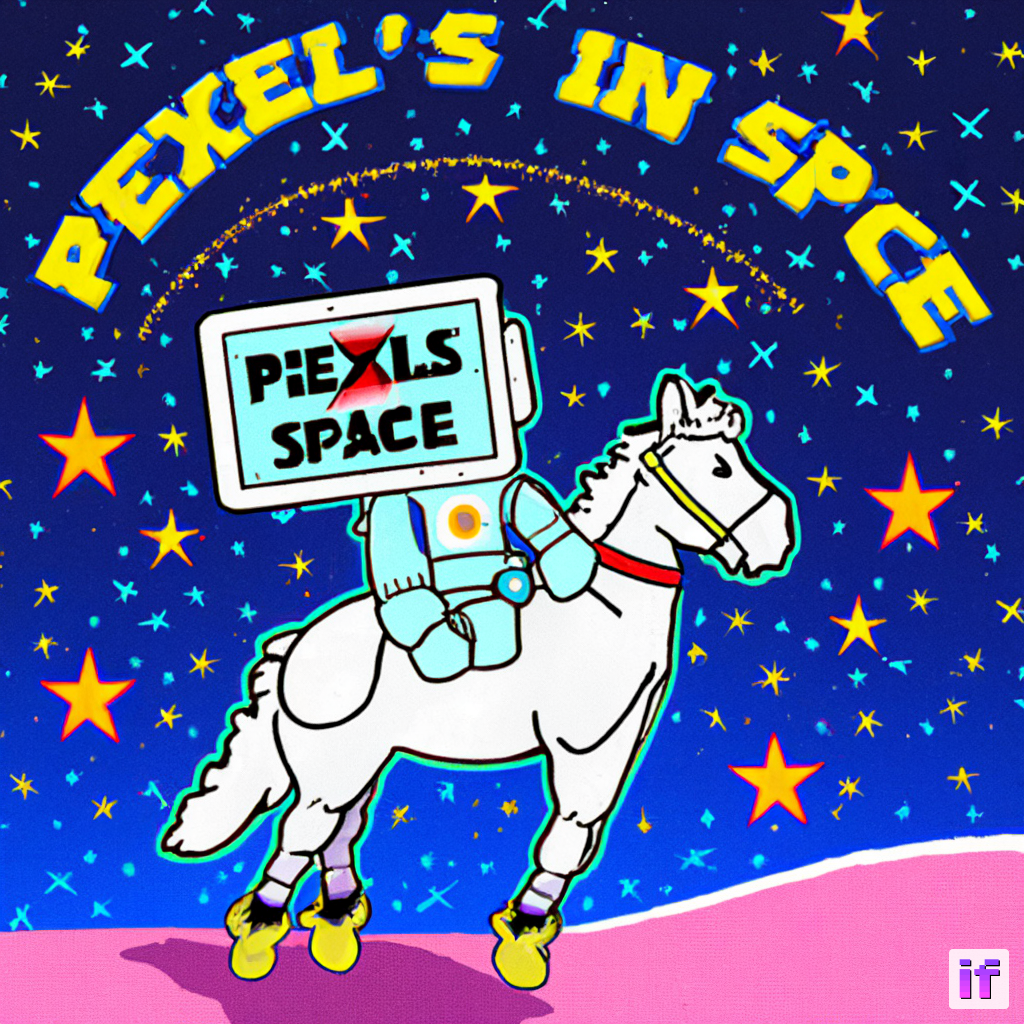

In [ ]:
pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

## Image variation

The same IF checkpoints can also be used for text guided image variation and inpainting. The core diffusion process is the same as text to image generation except the initial noised image is created from the image to be varied or inpainted.

To run image variation, load the same checkpoints with `IFImg2ImgPipeline.from_pretrained` and `IFImg2ImgSuperResolution.from_pretrained`.

The API's for memory optimization are all the same!

### 1. Load text encoder

In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0",
    subfolder="text_encoder", 
    device_map="auto", 
    load_in_8bit=True, 
    variant="8bit"
)

### 2. Create text embeddings

Note that we use the new `IFImg2ImgPipeline` instead of the original `DiffusionPipeline` class.

In [ ]:
from diffusers import IFImg2ImgPipeline

pipe = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0", 
    text_encoder=text_encoder, 
    unet=None, 
    device_map="auto"
)

In [ ]:
prompt = 'anime style'
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

### 3. Free memory



In [ ]:
del text_encoder
del pipe

In [ ]:
flush()

### 4. Load input data

We will download our input image from a dataset on the Hugging Face hub. 

The image variation and masking pipelines take both PIL images and raw tensors. View the docstrings for more indepth documentation on expected inputs.

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

original_image = hf_hub_download("diffusers/docs-images", repo_type="dataset", filename="slaps_roof.png")
original_image = Image.open(original_image)

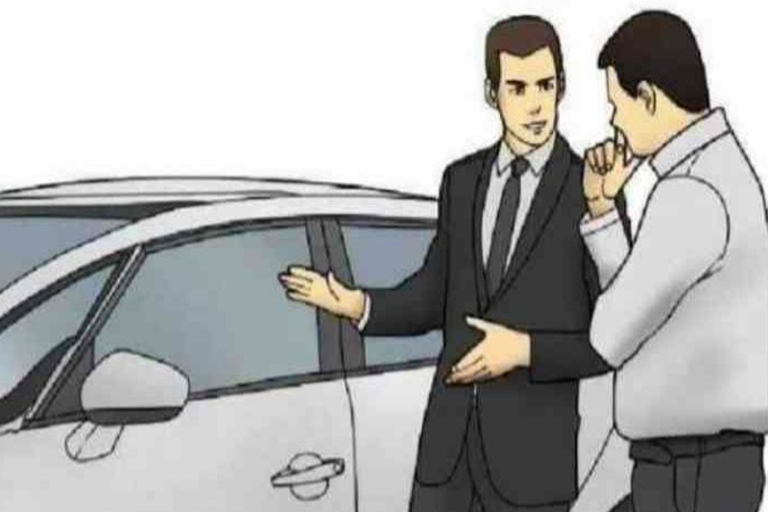

In [ ]:
original_image

### 5. Run the main diffusion process

In [ ]:
pipe = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Pass both the input image and the prompt embeddings

In [ ]:
generator = torch.Generator().manual_seed(0)
image = pipe(
    image=original_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

View outputs

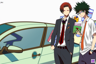

In [ ]:
pil_image = image
pil_image = (pil_image / 2 + 0.5).clamp(0, 1)
pil_image = pil_image.cpu().permute(0, 2, 3, 1).float().numpy()
pil_image = DiffusionPipeline.numpy_to_pil(pil_image)
pipe.apply_watermark(pil_image)

pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

### 6. Super Resolution

For super resolution, load the checkpoint with `IFImg2ImgSuperResolutionPipeline`.

In [ ]:
from diffusers import IFImg2ImgSuperResolutionPipeline

pipe = IFImg2ImgSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

The image variation super resolution pipeline requires the generated image as well as the original image.

In [ ]:
image = pipe(
    image=image,
    original_image=original_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

View output

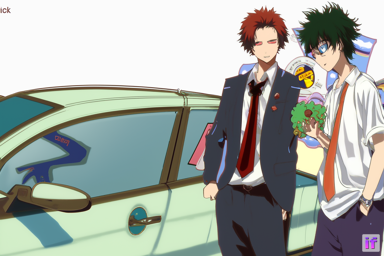

In [ ]:
pil_image = image
pil_image = (pil_image / 2 + 0.5).clamp(0, 1)
pil_image = pil_image.cpu().permute(0, 2, 3, 1).float().numpy()
pil_image = DiffusionPipeline.numpy_to_pil(pil_image)
pipe.apply_watermark(pil_image)

pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

### 7. Stable Diffusion x4 Upscaler

Create the pipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Run inference

In [ ]:
pil_image = pipe(prompt, generator=generator, image=image).images

Add watermark

In [ ]:
sd_x4_apply_watermark(pil_image)

View outputs

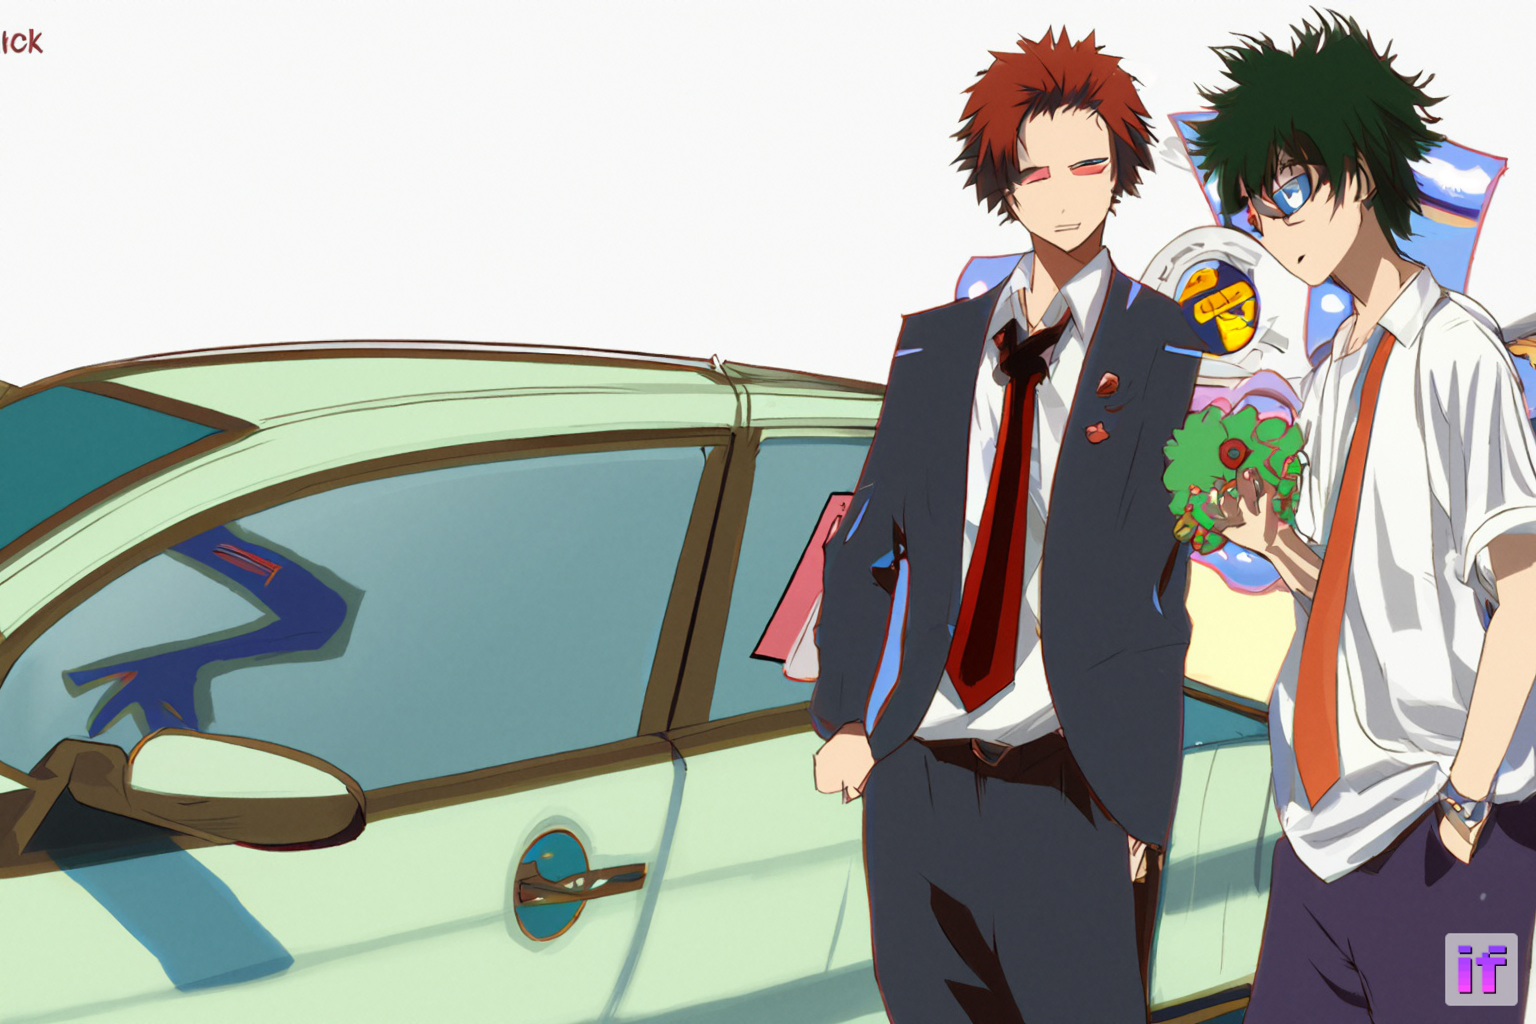

In [ ]:
pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

## Inpainting

The IF inpainting pipeline is the same as the image variation pipeline except 
only a select area of the image, specified by an image mask, is noised and then denoised.

### 1. Load text encoder


In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0",
    subfolder="text_encoder", 
    device_map="auto", 
    load_in_8bit=True, 
    variant="8bit"
)

### 2. Create text embeddings

In [ ]:
from diffusers import IFInpaintingPipeline

pipe = IFInpaintingPipeline.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0", 
    text_encoder=text_encoder, 
    unet=None, 
    device_map="auto"
)

In [ ]:
prompt = 'the text, "just stack more layers"'
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

### 3. Free memory

In [ ]:
del text_encoder
del pipe

In [ ]:
flush()

### 4. Load input data

We load both the input image, and the mask which specifies which part of the image will be inpainted.

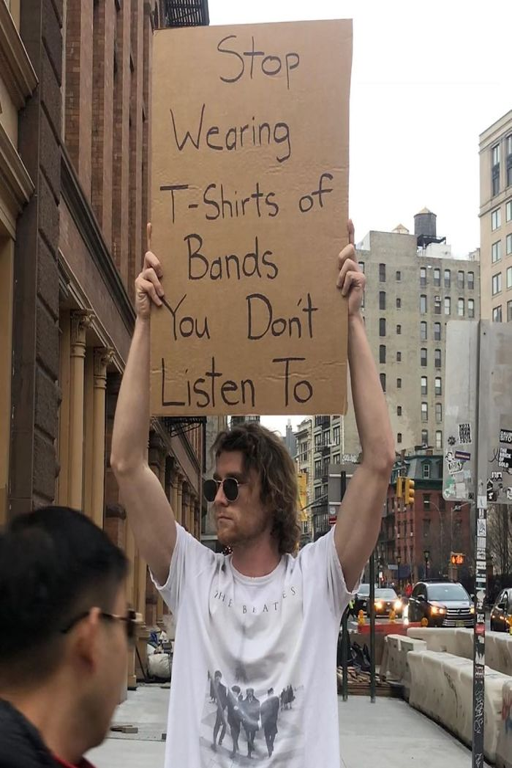

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

original_image = hf_hub_download("diffusers/docs-images", repo_type="dataset", filename="sign_man.png")
original_image = Image.open(original_image)

original_image

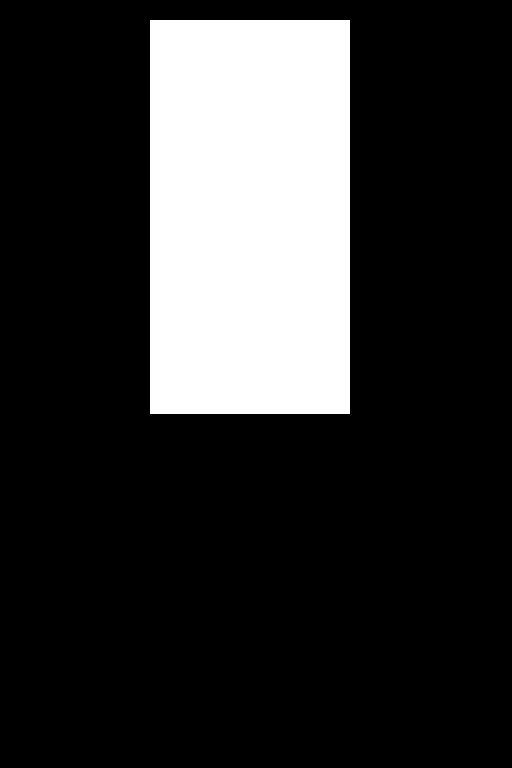

In [ ]:
mask_image = hf_hub_download("diffusers/docs-images", repo_type="dataset", filename="sign_man_mask.png")
mask_image = Image.open(mask_image)

mask_image

### 5. Run the main diffusion process

In [ ]:
pipe = IFInpaintingPipeline.from_pretrained(
    "DeepFloyd/IF-I-IF-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Pass the input image, the mask image, and the prompt embeddings

In [ ]:
image = pipe(
    image=original_image,
    mask_image=mask_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

View output

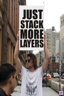

In [ ]:
pil_image = image
pil_image = (pil_image / 2 + 0.5).clamp(0, 1)
pil_image = pil_image.cpu().permute(0, 2, 3, 1).float().numpy()
pil_image = DiffusionPipeline.numpy_to_pil(pil_image)
pipe.apply_watermark(pil_image)

pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

### 6. Super resolution

For super resolution, load the checkpoint with `IFInpaintingSuperResolutionPipeline`.

In [ ]:
from diffusers import IFInpaintingSuperResolutionPipeline

pipe = IFInpaintingSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

The inpainting super resolution pipeline requires the generated image, the original image, the mask image, and the prompt embeddings.

In [ ]:
image = pipe(
    image=image,
    original_image=original_image,
    mask_image=mask_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

View output

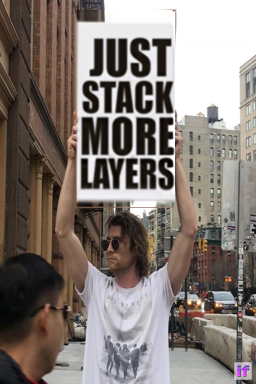

In [ ]:
pil_image = image
pil_image = (pil_image / 2 + 0.5).clamp(0, 1)
pil_image = pil_image.cpu().permute(0, 2, 3, 1).float().numpy()
pil_image = DiffusionPipeline.numpy_to_pil(pil_image)
pipe.apply_watermark(pil_image)

pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

### 7. Stable Diffusion x4 Upscaler

Create the pipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Run inference

In [ ]:
pil_image = pipe(prompt, generator=generator, image=image).images

Add watermark

In [ ]:
sd_x4_apply_watermark(pil_image)

View outputs

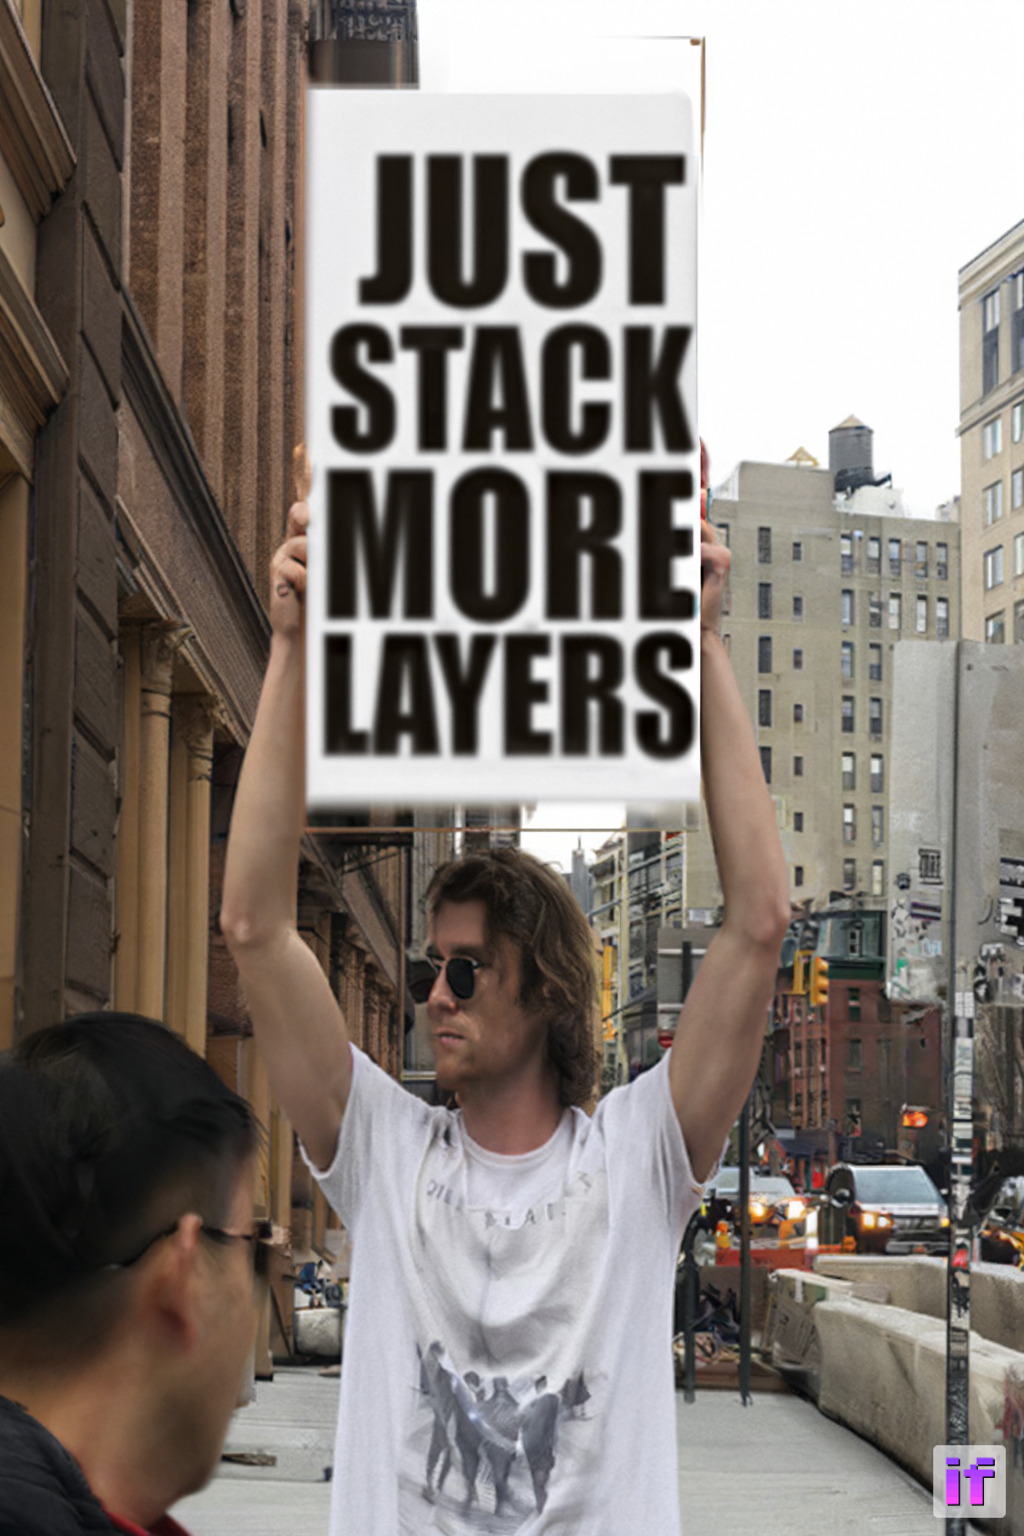

In [ ]:
pil_image[0]

Free memory

In [ ]:
del pipe

In [ ]:
flush()

## Summary

IF in 32 bit floating point precision uses 40 GB of weights in total. We showed how using only open source models and libraries, IF can be ran on a free tier Google Colab instance.

The ML ecosystem benefits deeply from the sharing of open tools and open models. This notebook alone used models from DeepFloyd, StabilityAI, and LAION. The libraries used -- Diffusers, Transformers, Accelerate, and bitsandbytes -- all benefit from countless contributors from different organizations.

A massive thank you to the DeepFloyd team for the creation and open sourcing of IF, and for contributing to the democratization of good machine learning. 